In [1]:
#3059 missing
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

from utils import label_accuracy_score, add_hist
import cv2

import numpy as np
import pandas as pd

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO


#!pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch


plt.rcParams['axes.grid'] = False



In [18]:
%matplotlib inline

dataset_path  = '../../data'
anns_file_path = dataset_path + '/' + 'train_all_new.json'

data = []
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

anns = dataset['annotations']
categories = dataset['categories']

data = [ann['image_id'] for ann in anns]
data2 = [ann['id'] for ann in anns]
data3 = [ann['area'] for ann in anns]
data4 = [ann['category_id']for ann in anns]

cat_names = [cat['name'] for cat in categories]

df = pd.DataFrame({'image_id': data, 'id': data2, 'area': data3, 'category_id': data4})
coco = COCO()
coco = COCO(anns_file_path)


#3059 없음  3466 번호 끝! 

loading annotations into memory...
Done (t=3.10s)
creating index...
index created!


In [3]:
catIds = coco.getCatIds()
cats = coco.loadCats(catIds)

### category distribution in train_set

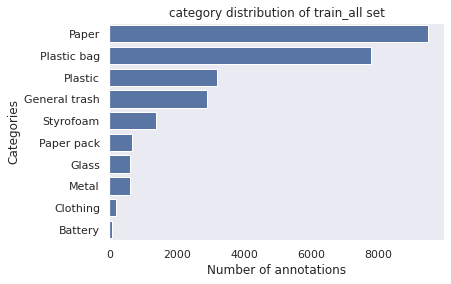

In [20]:
nr_cats = len(categories)
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']-1] += 1

df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

plt.title("category distribution of train_all set")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

## 이미지 당 segmenation의 총 area를 확인한다. 
- 1)Just Area는 겹치는 부분을 제거하지 않은 경우 (해당 경우는 512 * 512 보다 큰 area도 목격된다.)
- 2) Mask Area는 이미지에서 MASK 된 부분만 선택하는 구현으로 겹치는 부분이 제거된 크기이다. 
    - 2)의 구현은 mask 된 부분의 pixel수를 세는 방식으로 구현 

### Just Area

In [4]:
tmp_df = df.groupby('image_id').sum().sort_values('area')
tmp_df

,id,area,category_id
image_id,,,
256,6430,2182.5,6
2564,23938,2616.0,1
3287,26501,2690.5,9
248,1572,3018.0,6
263,1634,3463.0,3
...,...,...,...
2087,131166,308667.0,48
3130,178794,348416.5,51
1357,129157,349769.5,40


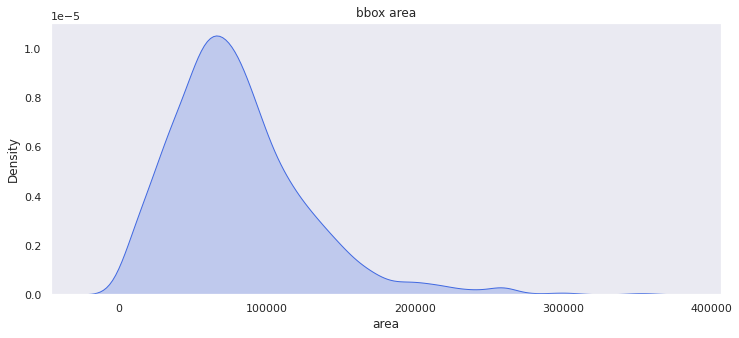

In [6]:
fig, ax = plt.subplots(1,1, figsize=(12, 5))
sns.kdeplot(x='area', data=tmp_df, ax=ax,color='royalblue',fill=True)
ax.set_title('bbox area')
plt.show()

### MASK area

In [7]:
area = []
img_ids = []
category_ids = []
def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

for img_id in set(df.image_id):
    _tmp = []
    image_infos = coco.loadImgs(img_id)[0]
    catIds = coco.getCatIds()
    cats = coco.loadCats(catIds)
    ann_ids = coco.getAnnIds(imgIds=image_infos['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(ann_ids)
 

    masks = np.zeros((image_infos["height"], image_infos["width"]))

    for ann in anns:
        className = get_classname(ann['category_id'], cats)
        pixel_value = cat_names.index(className)+1
        masks[coco.annToMask(ann) == 1] = pixel_value
        _tmp.append(ann['category_id'])
    #print(img_id,  np.count_nonzero(masks!=0))
    category_ids.append(_tmp)
    img_ids.append(img_id)
    area.append(np.count_nonzero(masks!=0)) 
    #pd_final.append(pd.DataFrame({"image_id": [img_id], "area": [np.count_nonzero(masks!=0)]}), ignore_index=True)
        
    

In [9]:
mask_df =  pd.DataFrame({"image_id": img_ids, "area": area})
mask_df = mask_df.sort_values('area')

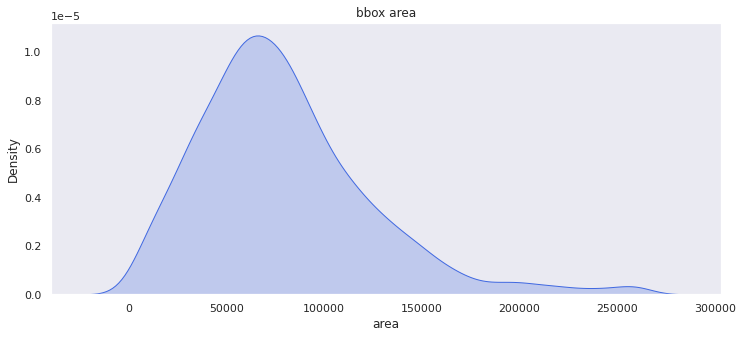

In [10]:
fig, ax = plt.subplots(1,1, figsize=(12, 5))
sns.kdeplot(x='area', data=mask_df, ax=ax,color='royalblue',fill=True)
ax.set_title('bbox area')
plt.show()

### category area distribution
- 각 카테고리 별 area 크기 비교 

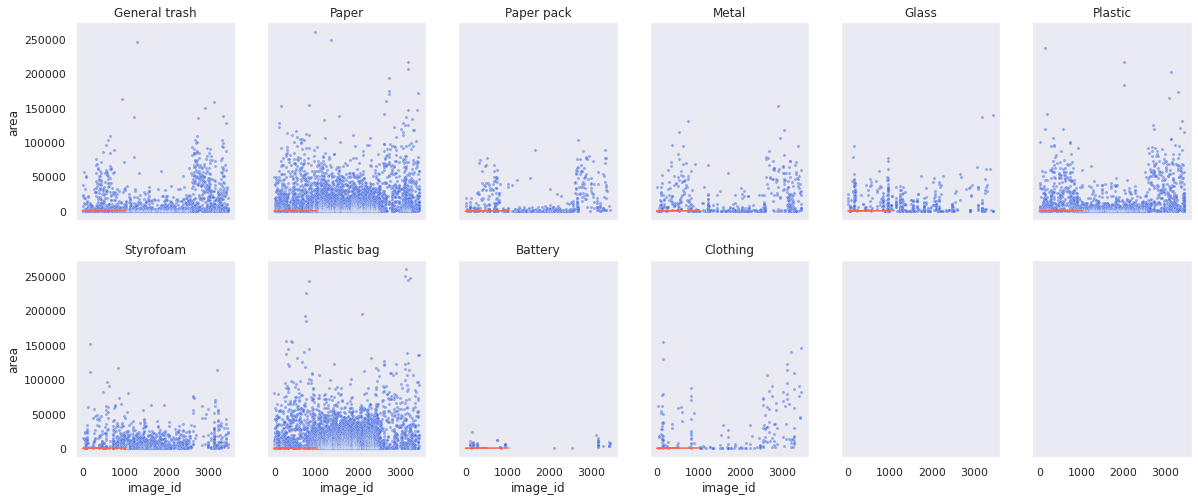

In [11]:
fig, axes = plt.subplots(2,6, figsize=(20, 8),sharey=True,sharex=True)
axes = axes.flatten()

for i in range(10):
    sns.scatterplot(x='image_id',y='area',data=df[df['category_id']==i+1],ax=axes[i],color='royalblue', s= 10,alpha=0.5)
    x1,x2 = [0, 1024], [0, 1024*0.5]
    y1,y2 = [0, 1024*0.5], [0, 1024]
    
    axes[i].plot(x1, y1,color = 'tomato')
    axes[i].plot(x2, y2,color = 'tomato')
    axes[i].set_title(categories[i]['name'])
plt.show()

### category num distribution per image
- 한 이미지 당 등장하는 카테고리 개수 비교 

In [12]:
category_df = df.groupby('image_id').apply(lambda d: len(set(d['category_id'])))
category_df = category_df.to_frame('category_count').reset_index()
tmp = category_df["category_count"].value_counts().to_frame( "category_id")
tmp

,category_id
1,1335
2,786
3,625
4,397
5,221
6,90
7,10
8,2


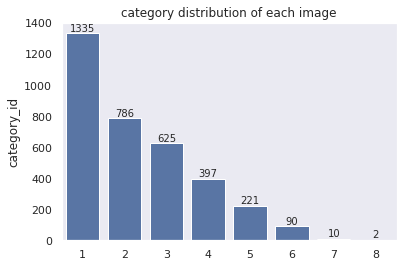

In [13]:
plt.title("category distribution of each image")
plot_1 = sns.barplot(x= tmp.index , y = "category_id" ,data=tmp , label="Total", color="b")
plot_1.bar_label(plot_1.containers[0])
print()

- `EDA` 결론: 각 이미지 별로 area 의 크기 차이와 등장하는 category (category의 수가 항상 등장하는 object의 수를 뜻하지는 않는다. 잘린 경우도 있고, 동일 class의 object 가 여러개 등장하기도 함, 하지만 이미지 visualization 결과를 통해 확인 했듯이 object가 한개라도 여러 조각으로 나눠진 경우가 다수 존재)